## Description:

This file contains:
* Predictions on unseen GA Data
* EDA on obtained results

In [1]:
"""Helper"""
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
import numpy as np
from numpy import mean
import time
import joblib
from google.cloud import bigquery
from google.cloud import storage
import pickle

"""Visualization"""
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

"""BQ"""
import google.auth
from google.cloud import bigquery
from google.cloud import bigquery_storage
import time

"""GCS Utils"""
from gcs_utils import upload_serialized_file, upload_csv_file, download_file

bqclient = bigquery.Client()
bqstorageclient = bigquery_storage.BigQueryReadClient()

**Download prediction data and load**
* Sample of randomly chosen unseen 500k fullvids and their pre-processed GA Data
* Data for July 2,'21 taken from ml_data.user_pred_data table

In [2]:
start_time = time.time()

query_string = """ SELECT * FROM `api-project-901373404215.skt.dm_processed_prediction_data` """

prediction_df = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

print("--- %s seconds ---" % (time.time() - start_time))

--- 6.025964975357056 seconds ---


In [3]:
print(prediction_df.shape)
prediction_df.head()

(500000, 105)


,fullvid_pred,sessions,pageViews,pageViews_median,t1_automotive,t1_business_and_finance,t1_careers,t1_medical_health,t1_news_and_politics,t1_personal_finance,...,contentAge,contentAge_median,contentScrolled,contentScrolled_median,contentPageViews,contentScrollDepth,contentTimeOnPage,sessionsDelta,sessionsDelta_median,visit_freq
0,4043737703948602660,0.05,3.25,2.76,1.49,0.43,-0.30,-0.30,-0.43,0.01,...,-0.46,-0.28,0.28,0.21,-0.46,0.16,-0.14,-0.55,-0.36,1.20
1,8197837189386254867,0.07,1.96,1.25,0.98,0.09,-0.27,0.19,-0.11,0.03,...,-0.53,-0.28,-0.93,-0.99,-0.45,0.43,-0.78,-0.55,-0.36,3.81
2,7880903748671074432,-0.00,-0.42,-0.25,0.07,-0.23,0.02,-0.17,0.94,0.44,...,-0.56,-0.28,-1.49,-1.46,-0.21,0.87,-1.24,-0.54,-0.35,0.29
3,564939456903766488,-0.00,-0.46,-0.25,-0.18,-0.32,-0.07,1.80,0.09,-0.07,...,-0.55,-0.28,-1.49,-1.46,-0.19,0.79,-1.27,-0.52,-0.35,0.32
4,4412308716135113781,-0.00,-0.50,-0.25,-0.18,-0.10,-0.34,0.58,0.29,0.21,...,-0.57,-0.28,0.13,0.21,-0.26,0.82,-1.16,-0.54,-0.35,0.30


**Download model and load**

* About the model:
    * Final chosen model is an ensemble model, with threshold 0.6 and trained on:
        * 61,983 emails - zoom info data till 01-Jul-21

In [4]:
BUCKET_NAME = 'zoominfo-user-modeling'

bucket_folder = 'decision-makers'

file_name = 'dm_voting_classifier.joblib'
download_file(BUCKET_NAME, bucket_folder, file_name)

model = joblib.load(file_name)
model

VotingClassifier(estimators=[('log_reg',
                              LogisticRegression(C=78.47599703514607,
                                                 penalty='l1',
                                                 solver='liblinear')),
                             ('gaussian_naive_bayes',
                              GaussianNB(var_smoothing=0.1)),
                             ('light_gbm',
                              LGBMClassifier(max_depth=20, num_leaves=200,
                                             random_state=1)),
                             ('random_forest',
                              RandomForestClassifier(max_depth=50,
                                                     max_features=3,
                                                     min_samples_leaf=50,
                                                     min_samples_split=8,
                                                     random_state=1))],
                 voting='soft')

### Predict on unseen GA data

In [5]:
unseen_ga = prediction_df.copy()

# drop client col
unseen_ga.drop('fullvid_pred', axis=1, inplace=True)

In [6]:
# 0.6 threshold
preds_60 = model.predict_proba(unseen_ga)
preds_60 = np.where(preds_60[:,1]>0.6, 1, 0)

print("Thresholding - 60. Predicted distribution:")
print(pd.Series(preds_60).value_counts())
print()
print("DMs %:", round(len(preds_60[preds_60==1])/len(preds_60)*100))

Thresholding - 60. Predicted distribution:
0    337812
1    162188
dtype: int64

DMs %: 32


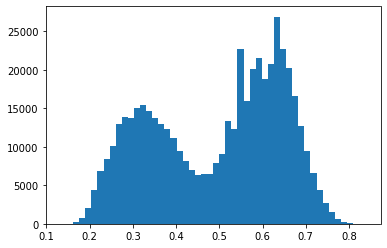

In [7]:
# number of folks with probability around 0.5 is less - which means model is able to separate DMs and Non-DMs

preds_probs = model.predict_proba(unseen_ga)
plt.hist(preds_probs[:,1], bins=50)
plt.show()

In [8]:
# join predicted class to dataframe

prediction_df["predicted"] = preds_60 # preds
prediction_df["predicted_class"] = np.where(prediction_df["predicted"]==1, 'DM', 'Non-DM')

print(prediction_df.shape)
print()
print(prediction_df.predicted_class.value_counts())

test = prediction_df[['fullvid_pred', 'predicted_class']]
test.tail()

(500000, 107)

Non-DM    337812
DM        162188
Name: predicted_class, dtype: int64


,fullvid_pred,predicted_class
499995,7812096268432929010,DM
499996,18033710821347308148,Non-DM
499997,7061772404926923587,Non-DM
499998,530788694467832945,Non-DM
499999,5588927608299171436,Non-DM


In [9]:
def dm_eda(data, columns):
    
    # groupby - calculate sum of pageviews in each category - calculate percentage
    eda_df = data.groupby('predicted_class')[columns].sum().apply(lambda x: (x/x.sum())*100,
                                                                  axis=1).T.sort_values('DM', ascending=False)
    #rename
    eda_df = eda_df.rename(columns={"DM": "% of DM pvs", "Non-DM": "% of Non-DM pvs"})

    #calculate rank
    eda_df['DM_rank'] = eda_df['% of DM pvs'].rank(ascending=False).astype(int)
    eda_df['NonDM_rank'] = eda_df['% of Non-DM pvs'].rank(ascending=False).astype(int)
    
    return eda_df

* **Prepare data for EDA**
    * Fetch original GA data for these 500k folks and join

In [10]:
query_string = """ SELECT * FROM `api-project-901373404215.skt.dm_orig_prediction_data` """

df_original = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

print(df_original.shape)

df_original.head(1)

(500000, 708)


,fullvid_pred,pc_advisor,pc_asia,pc_billionaires,pc_business,pc_consumer,pc_entrepreneurs,pc_forbes_finds,pc_home,pc_industry,...,contentScrolled,contentScrolled_median,contentPageViews,contentScrollDepth,contentTimeOnPage,sessionsDelta,sessionsDelta_median,distinct_articles,visit_freq,subscription_status
0,7554906002807962224,0,0,1,1,0,0,0,0,0,...,5488.00,5488.00,11766.50,0.55,89.82,514667.00,514667.00,2,2,0


In [11]:
# join predictions with non-normalized GA data for EDA

merged = pd.merge(df_original, test , 
                  on = "fullvid_pred", 
                  how="left")

print(merged.shape)
print(len(merged.fullvid_pred.unique()))

merged.head(1)

(500000, 709)
500000


,fullvid_pred,pc_advisor,pc_asia,pc_billionaires,pc_business,pc_consumer,pc_entrepreneurs,pc_forbes_finds,pc_home,pc_industry,...,contentScrolled_median,contentPageViews,contentScrollDepth,contentTimeOnPage,sessionsDelta,sessionsDelta_median,distinct_articles,visit_freq,subscription_status,predicted_class
0,7554906002807962224,0,0,1,1,0,0,0,0,0,...,5488.00,11766.50,0.55,89.82,514667.00,514667.00,2,2,0,DM


## EDA

In [12]:
numerical_cols = ['sessions', 'pageViews', 'pageViews_median', 'scrollDepth', 'scrollDepth_norm', 'timeOnPage', 'timeOnPage_median', 
                  'timeOnPage_norm', 'sessionsDelta', 'sessionsDelta_median', 'countries', 'devices', 'channels', 'sections', 'authors',  
                  'contentPageViews', 'contentViewsRate', 'contentAge', 'contentAge_median', 'contentScrolled', 'contentScrolled_median', 
                  'contentScrollDepth', 'contentTimeOnPage', 'bounceRate', 'distinct_articles', 'visit_freq']


# define list of categorical cols

tier1_cols =        [col for col in merged.columns if 't1_' in col]
tier2_cols =        [col for col in merged.columns if 't2_' in col]
pchannel_cols =     [col for col in merged.columns if 'pc_' in col]
psection_cols =     [col for col in merged.columns if 'ps_' in col]
device_OS_cols =    [col for col in merged.columns if 'dOS_' in col]
device_cat_cols =   [col for col in merged.columns if 'dC_' in col]
referral_cols =     [col for col in merged.columns if 'rf_' in col]
country_cols =      [col for col in merged.columns if 'ct_' in col]
subsc_cols =        ['subscription_status']

# remove an incorrect element 
pchannel_cols.remove('t2_pc_games')
country_cols.remove('distinct_articles')
# remove t2_pc_games from tier2

# combine all categorical columns
categorical_cols = tier1_cols + tier2_cols + pchannel_cols + psection_cols + device_OS_cols + device_cat_cols + referral_cols + country_cols + subsc_cols

* Observations:
    * DMs are more likely to read:  
        * leadership, 
        * business & finance, 
        * billionaires, 
        * small business,
        * travel
        
    * Non-DMs are more likely to read: 
        * money
        * video game
        * real estate/home
        * lifestyle 
        
    * Non-DMs have slightly more unique pvs per session and avg. content pvs. But DMs have slightly more avg. time on page

In [13]:
# DM - busi, billionaire, leadership, innovation, small busi
# Non-DM - money, lifestyle, real estate, home

dm_eda(merged, pchannel_cols).head(20)

predicted_class,% of DM pvs,% of Non-DM pvs,DM_rank,NonDM_rank
pc_business,24.80,7.99,1,4
pc_billionaires,13.57,1.63,2,10
pc_money,11.81,21.13,3,2
pc_none,10.66,4.78,4,6
pc_leadership,9.84,4.35,5,7
pc_lifestyle,8.55,11.11,6,3
pc_innovation,6.87,3.10,7,8
pc_small_business,4.39,1.24,8,11
pc_other,3.44,2.30,9,9
pc_home,3.34,7.17,10,5


In [14]:
# DM - right: travel, forbeswomen, crypto, entrepreneurs, leadership strategy, small business strategy, cmo network
# Non-DM - personal finance, investing, games

dm_eda(merged, psection_cols).head(20)

predicted_class,% of DM pvs,% of Non-DM pvs,DM_rank,NonDM_rank
ps_none,41.60,60.74,1,1
ps_other,15.92,18.70,2,2
ps_markets,4.16,2.65,3,4
ps_travel,4.12,0.49,4,13
ps_hollywood_and_entertainment,3.33,0.97,5,8
ps_forbeswomen,3.33,0.73,6,11
ps_crypto_and_blockchain,3.26,0.32,7,19
ps_entrepreneurs,2.92,0.93,8,9
ps_sportsmoney,1.98,0.61,9,12
ps_leadership_strategy,1.46,0.48,10,14


In [15]:
dm_eda(merged, psection_cols).sort_values('NonDM_rank').head(10)

predicted_class,% of DM pvs,% of Non-DM pvs,DM_rank,NonDM_rank
ps_none,41.60,60.74,1,1
ps_other,15.92,18.70,2,2
ps_investing,1.36,2.96,11,3
ps_markets,4.16,2.65,3,4
ps_personal_finance,0.80,2.06,19,5
ps_retirement,0.23,1.84,37,6
ps_games,0.05,0.98,45,7
ps_hollywood_and_entertainment,3.33,0.97,5,8
ps_entrepreneurs,2.92,0.93,8,9
ps_arts,0.59,0.89,25,10


In [16]:
# DM - business and finance, medical health; (wrong: news+politics, personal finance)
# Non-DM - video game, style and fashion, shopping, real estate

dm_eda(merged, tier1_cols).head(21)

predicted_class,% of DM pvs,% of Non-DM pvs,DM_rank,NonDM_rank
t1_other,41.48,45.34,1,1
t1_business_and_finance,16.40,3.54,2,4
t1_news_and_politics,11.64,1.70,3,6
t1_personal_finance,6.04,1.42,4,7
t1_medical_health,5.64,0.76,5,9
t1_technology_and_computing,4.44,0.98,6,8
t1_travel,2.21,3.25,7,5
t1_sports,2.03,0.57,8,10
t1_food_and_drink,1.02,0.21,9,19
t1_style_and_fashion,0.91,5.19,10,3


In [17]:
dm_eda(merged, tier1_cols).sort_values('NonDM_rank').head(11)

predicted_class,% of DM pvs,% of Non-DM pvs,DM_rank,NonDM_rank
t1_other,41.48,45.34,1,1
t1_real_estate,0.62,33.68,18,2
t1_style_and_fashion,0.91,5.19,10,3
t1_business_and_finance,16.40,3.54,2,4
t1_travel,2.21,3.25,7,5
t1_news_and_politics,11.64,1.70,3,6
t1_personal_finance,6.04,1.42,4,7
t1_technology_and_computing,4.44,0.98,6,8
t1_medical_health,5.64,0.76,5,9
t1_sports,2.03,0.57,8,10


In [18]:
# DM - business, economy, vaccine, disease, industries; (wrong: personal investing, personal debt)
# Non-DM - style and fashion, shopping, real estate

dm_eda(merged, tier2_cols).head(21)

predicted_class,% of DM pvs,% of Non-DM pvs,DM_rank,NonDM_rank
t2_other,45.64,46.50,1,1
t2_business,8.00,1.88,2,6
t2_politics,7.24,0.74,3,10
t2_economy,4.56,0.66,4,11
t2_industries,3.78,0.99,5,8
t2_personal_investing,3.48,0.86,6,9
t2_computing,3.24,0.56,7,12
t2_diseases_and_conditions,3.21,0.50,8,13
t2_vaccines,1.79,0.20,9,19
t2_law,1.32,0.19,10,20


In [19]:
# pageViews - unique pvs per session - Non-DMs have it more
# contentPageViews - total article pvs - Non-DMs have it more
# contentTimeOnPage - DMs have it slightly more (except the extreme value)

merged.groupby('predicted_class')[['pageViews', 'contentPageViews', 'contentTimeOnPage']].describe().T

predicted_class                 DM     Non-DM
pageViews         count  162188.00  337812.00
                  mean        1.28       1.44
                  std         0.54       1.41
                  min         1.00       1.00
                  25%         1.00       1.00
                  50%         1.00       1.00
                  75%         1.40       1.67
                  max        15.00     130.00
contentPageViews  count  162188.00  337812.00
                  mean    70766.92   72166.73
                  std    111304.86  136152.14
                  min         0.00       0.00
                  25%      3336.00    4280.00
                  50%     19101.00   22437.62
                  75%     96668.12   76874.00
                  max   1108440.00 1690759.00
contentTimeOnPage count  162188.00  337812.00
                  mean       90.85      90.82
                  std        47.00      51.95
                  min         0.00       0.00
                  25%        59.72      59.02
                  50%        90.20      87.53
                  75%       119.78     121.46
                  max       553.20    1245.00

* Cross-checking with ZoomInfo C-level predictions for July 2, '21

In [20]:
query_string = """ SELECT * FROM `api-project-901373404215.lookalike.zoom_info_c_level` WHERE date='2021-07-02'  """

zoom_clevel = (
    bqclient.query(query_string)
    .result()
    .to_dataframe(bqstorage_client=bqstorageclient)
)

zoom_clevel.shape

(1307354, 3)

In [21]:
check_cs = pd.merge(zoom_clevel, merged[["fullvid_pred", "predicted_class"]], 
                    left_on="GA_fullVisitorId", right_on="fullvid_pred", how="inner")

* Final ZoomInfo DM model, threshold is raised at 0.6, match rate with ZoomInfo C-levels:
    * 70% C-levels also labelled as DMs
    * 30% C-levels labelled as Non-DMs

In [26]:
# In final DM model, threshold is raised at 0.6, match rate:
print(check_cs[check_cs.managementLevel =='C-level'][['managementLevel', 'predicted_class']].value_counts())

print()
print(round((8626/29073)*100))

managementLevel  predicted_class
C-level          DM                 20447
                 Non-DM              8626
dtype: int64

30


In [22]:
# In final DM model, threshold is raised at 0.6, match rate:
print(check_cs[check_cs.managementLevel =='C-level'][['managementLevel', 'predicted_class']].value_counts())

print()
print(round((8626/29073)*100))

managementLevel  predicted_class
C-level          DM                 20447
                 Non-DM              8626
dtype: int64

30


* NOTE: if threshold for ZoomInfo DM model was kept at 0.5, match rate with ZoomInfo C-levels:
    * 81% C-levels also labelled as DMs
    * 19% C-levels labelled as Non-DMs

In [25]:
# if threshold for DM model was kept at 0.5, match rate:

# print(check_cs[check_cs.managementLevel =='C-level'][['managementLevel', 'predicted_class']].value_counts())

print()
print("% of C-levels labelled as Non-DMs", round((5609/29073)*100))

# DO NOT RUN THIS CELL 


% of C-levels labelled as Non-DMs 19
